# Library Import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, Conv2D, concatenate, Dropout, LSTM, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 
import json
import pickle
import cv2
import nltk
from PIL import Image
from keras import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet121
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import time
import datetime
import io
import nltk.translate.bleu_score as bleu
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [221]:
!curl --header "Host: doc-34-9c-drive-data-export.googleusercontent.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9" --header "Cookie: AUTH_r6afnm0karqj1okdole1rkacqb5fsoqd_nonce=gj8ls46garbjm" --header "Connection: keep-alive" "https://doc-34-9c-drive-data-export.googleusercontent.com/download/j06g93fbtj5njke1mqq2kgpdnbq7jutj/dupaolllg2kdqsv1i81vnbcdoj6pl25j/1613371500000/ba3c4a44-c748-4f48-82da-6cff07cc6e77/100032109256450222774/ADt3v-OkPIXTCDiO-Y80HGrzOdefGVs0o7Lweb5l-NrxuORCVsbki6x_D9MjyKSIEl0PfvOCbB55nyORHdWS09vNcdjyWyd0nW-nzwK4h-Ma5t9uDl1hV-jwPNulUQHrYIXclR0r2KG-1VSELTuzRbdY5nLxgS-DX9cU2wmU7p3RN6HCK3Q1v3cOXWfdC3BQSAI9WAYRQUHqMGpUDaLxet0e2hAGz8DpMn73QzOf6ULSlH3k34TkHVI0dKlQTFBw2dWK0gIpgNPl27CLlzLhhm_THExZvjnqBHT2XcxQXaCPPEFXfXRBTzWVxaEleWwZ6aNjKDfk9lMO?authuser=0&nonce=gj8ls46garbjm&user=100032109256450222774&hash=c0u6av1q9rbijon7lt3bdonpl9ivcade" -L -o "NLMCXR_png-20210215T065710Z-001.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1308M  100 1308M    0     0  80.8M      0  0:00:16  0:00:16 --:--:-- 84.9M


In [ ]:
!unzip '/content/NLMCXR_png-20210215T065710Z-001.zip'

# Data import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [229]:
df = pd.read_csv('/content/drive/MyDrive/dl case study/last3.csv')
df = df.iloc[: , 1:]
df

,frontal,lateral,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,normal chest
1,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,no acute cardiopulmonary process
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,no active disease
3,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-1001.png,one increased opacity right upper lobe associa...
4,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,one increased opacity right upper lobe associa...
...,...,...,...
4045,CXR996_IM-2479-1001.png,CXR996_IM-2479-2001.png,heart size normal lungs clear no pneumothorax ...
4046,CXR997_IM-2479-1001.png,CXR997_IM-2479-2001.png,no acute cardiopulmonary abnormality
4047,CXR998_IM-2479-1001.png,CXR998_IM-2479-2001.png,no acute cardiopulmonary abnormality
4048,CXR999_IM-2480-3001.png,CXR999_IM-2480-2001.png,no acute cardiopulmonary abnormality


In [238]:
# we splitted data into train, test and validation
# test split ratio 0.05 of train data
# validation split ratio 0.25 of train data 
 
train.to_csv('/content/drive/MyDrive/dl case study/data split/train.csv')
test.to_csv('/content/drive/MyDrive/dl case study/data split/test.csv')
validation.to_csv('/content/drive/MyDrive/dl case study/data split/valiation.csv')

In [287]:
train = pd.read_csv('/content/drive/MyDrive/dl case study/data split/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dl case study/data split/test.csv')
validation = pd.read_csv('/content/drive/MyDrive/dl case study/data split/valiation.csv')

train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
validation = validation.iloc[:, 1:]

print("train data -     ",train.shape)
print('test data -      ',test.shape)
print('validation data -',validation.shape)

train data -      (2885, 3)
test data -       (203, 3)
validation data - (962, 3)


In [288]:
# Ad start and end token in datasets

train.impression      = '<start> ' + train.impression + ' <end>'
validation.impression = '<start> ' + validation.impression + ' <end>'
test.impression       = '<start> ' + test.impression + ' <end>'

In [289]:
train.head()

,frontal,lateral,impression
0,CXR318_IM-1500-1001.png,CXR318_IM-1500-2001.png,<start> no acute cardiopulmonary abnormality <...
1,CXR1777_IM-0509-1001.png,CXR1777_IM-0509-1002.png,<start> right upper lobe pneumonia considerati...
2,CXR1436_IM-0280-1001.png,CXR1436_IM-0280-1002.png,<start> one haziness right lung apex questiona...
3,CXR719_IM-2280-1001.png,CXR719_IM-2280-2001.png,<start> heart size normal lungs clear <end>
4,CXR3927_IM-2000-1001.png,CXR3927_IM-2000-2001.png,<start> stable position aortic stent normal ca...


In [290]:
validation.head()

,frontal,lateral,impression
0,CXR2433_IM-0975-2001.png,CXR2433_IM-0975-3001.png,<start> no acute cardiopulmonary abnormality <...
1,CXR1705_IM-0465-2001.png,CXR1705_IM-0465-2001.png,<start> one no acute cardiopulmonary abnormali...
2,CXR723_IM-2283-1001.png,CXR723_IM-2283-2001.png,<start> bibasilar atelectasis <end>
3,CXR227_IM-0859-4004.png,CXR227_IM-0859-1001.png,<start> cardiomegaly pulmonary interstitial ed...
4,CXR3098_IM-1450-1001.png,CXR3098_IM-1450-1002.png,<start> no acute cardiopulmonary abnormality <...


## Inception-V3 (pre-trained model)

In [446]:
 # used pre trained inception model 
  
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
input_layer  = model.input
output_layer = model.layers[-1].output

image_model = tf.keras.Model(input_layer, output_layer)
image_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [447]:
# shape of the input and output layer
input_layer, output_layer

(<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>)

In [448]:
image_1 = Input(shape=(256,256,3),name="image_1_features")
image_2 = Input(shape=(256,256,3),name="image_2_features")

# call the inception v3 model
image_1_out = image_model(image_1)
image_2_out = image_model(image_2)

merge = concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
model = Model(inputs=[image_1,image_2],outputs= merge)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1_features (InputLayer)   [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
image_2_features (InputLayer)   [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         21802784    image_1_features[0][0]           
                                                                 image_2_features[0][0]           
__________________________________________________________________________________________________
final_image_features (Concatena (None, 4096)         0           model[0][0]                

### Conclusion

* We used pre-trained inception-v3 model for the our Encoder task. Inception model is used for the classification task, we modified inception model for the our use.

* We removed last layer of the model for our use. Then we created one extra model. it will take two x ray images and return concate tensor of two diffrent image's tensors. 

# Preprocess of image data and text data 

## Image to tensor convert

In [449]:
def preprocess(image_path1, image_path2, path):
    '''
    input -- image 1 , image 2, image's path
    output -- image tensor
    process - convert two images into 256 X 256, then using inception model generate tensor (concate two image tensor)


    '''

    # join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # load the images
    img1 = image.load_img(image_path1, target_size=(256,256))
    img2 = image.load_img(image_path2, target_size=(256,256))

    # Convert PIL image to numpy array of 3-dimensions
    x1 = image.img_to_array(img1)
    x2 = image.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # preprocess the images using preprocess_input() from inception module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # create tensor
    tensor = model([x1,x2])
    
    return tensor

In [403]:
# create the tensor using train and validation data and store it in list

path = '/content/NLMCXR_png/'

# train data
image_train = [ ]
for col in tqdm(train.values):
    tensor = preprocess(col[0], col[1], path)
    image_train.append(tensor)

# validation data
image_validation = [ ]
for col in tqdm(validation.values):
    tensor = preprocess(col[0], col[1], path)
    image_validation.append(tensor)

print(f'shape of the train and validation image list are {len(image_train)} and  {len(image_validation)}')
print(f'shape of the train and validation image tensor are {image_train[0].shape} and  {image_validation[0].shape}')

In [251]:
image_train[0]

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[1.2293075 , 0.18309599, 0.2626134 , ..., 0.17583525, 0.04098015,
        0.33832347]], dtype=float32)>

In [252]:
image_validation[0]

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[0.11085363, 0.16118044, 0.4371643 , ..., 0.34702724, 0.10194168,
        0.7450536 ]], dtype=float32)>

In [253]:
for i in [image_train, image_validation]:
    print(len(i))

2885
962


In [254]:
# save the tensor in numpy format
np.save("/content/drive/MyDrive/dl case study/train_image_features_3", image_train)
np.save("/content/drive/MyDrive/dl case study/validation_image_features_3",  image_validation) 

In [413]:
image_train = np.load('/content/drive/MyDrive/dl case study/train_image_features_3.npy')
image_validation = np.load('/content/drive/MyDrive/dl case study/validation_image_features_3.npy')

## Text data convert into tokens

In [414]:
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n')

# sequence in train, test and validation 
token.fit_on_texts(train['impression'])
token_train       = token.texts_to_sequences(train['impression'])
token_val         = token.texts_to_sequences(validation['impression'])
print('Vocab size - ', len(token.word_index))

# padding in the train, test and validation 
max_len = 60
pad_train = pad_sequences(token_train, maxlen = max_len, dtype='int32', padding='post', truncating='post')
pad_val   = pad_sequences(token_val,   maxlen = max_len, dtype='int32', padding='post', truncating='post')
print(pad_train[:1])

word_idx = {}
idx_word = {}
for k, v in (token.word_index).items(): 
    word_idx[k] = v
    idx_word[v] = k
    
vocab_size = len(word_idx)+1

Vocab size -  1278
[[1 3 4 5 8 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Emebdding Matrix

In [443]:
# Create embedding matrix

list_sents = [ ]
for sent_tok in train.impression :
    for sent in nltk.sent_tokenize(sent_tok) :
        # replace start and end token, otherwise list_sent got like  <, start ,> 

        sent = sent.replace('<start>', "")
        sent = sent.replace('<end>', "")

        list_sents.append(['<start>' , *nltk.word_tokenize(sent) , '<end>'])
        

w2v = Word2Vec(sentences= list_sents, size=300, window=5, min_count=1, workers=4)

In [444]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(token.word_index.items()):
  embedding_vector = w2v.wv[word]
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [419]:
embedding_matrix.shape

(1279, 300)

## Create Datasets

In [455]:
#we prepare the data set with the image fetaures and the reports
# https://www.tensorflow.org/tutorials/text/image_captioning

batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, pad_train))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((image_validation, pad_val))
val_dataset = val_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [456]:
for i,j in train_dataset :
    print(i,j)
    break

tf.Tensor(
[[[0.5325463  0.3624624  0.0585576  ... 0.4226645  0.42849356 1.333325  ]]

 [[0.14254104 0.0452509  0.43025726 ... 0.27186686 0.06306323 1.7221673 ]]

 [[0.56457067 0.36196062 0.23990451 ... 0.43151414 0.01316739 1.401146  ]]

 ...

 [[0.5415963  0.3637952  0.18710898 ... 0.7375311  0.00925663 1.0335515 ]]

 [[0.7702283  0.37776598 0.09516761 ... 0.5411774  0.02496511 0.8531066 ]]

 [[0.3838101  0.44045532 0.16716838 ... 0.02444487 0.16601722 1.2334771 ]]], shape=(20, 1, 4096), dtype=float32) tf.Tensor(
[[  1   3  79 ...   0   0   0]
 [  1  81 163 ...   0   0   0]
 [  1   3   4 ...   0   0   0]
 ...
 [  1   7   3 ...   0   0   0]
 [  1 115  13 ...   0   0   0]
 [  1   3   4 ...   0   0   0]], shape=(20, 60), dtype=int32)


In [457]:
for i,j in val_dataset :
    print(i,j)
    break

tf.Tensor(
[[[0.67641056 0.7034165  0.09944677 ... 0.64694154 0.20622215 0.958292  ]]

 [[0.3063834  0.3222634  0.05088686 ... 0.04225094 0.06145553 1.3282868 ]]

 [[0.35941914 0.03182561 0.14840858 ... 0.43980214 1.0440316  0.7621462 ]]

 ...

 [[0.06795635 0.9036146  0.44279492 ... 0.08515593 0.         1.0765457 ]]

 [[0.2526847  0.9873494  0.29835075 ... 0.4496507  0.05646434 1.7526191 ]]

 [[0.5462318  0.74628544 0.273147   ... 0.26964867 0.3457415  1.8400056 ]]], shape=(20, 1, 4096), dtype=float32) tf.Tensor(
[[ 1  3  4 ...  0  0  0]
 [ 1  3  4 ...  0  0  0]
 [ 1  7 25 ...  0  0  0]
 ...
 [ 1  7 25 ...  0  0  0]
 [ 1  3 24 ...  0  0  0]
 [ 1  3  4 ...  0  0  0]], shape=(20, 60), dtype=int32)


## Model

In [404]:
# image input
input_layer = Input(shape=(1,4096), name = 'Image input')
encoder_out = Dense(300, name = 'image_dense')(input_layer)

input_layer_text = tf.keras.layers.Input(shape=(1,), name = 'text inout')
x = Embedding(input_dim = vocab_size, output_dim=300, input_length=max_len, mask_zero=True, trainable=False, weights=[embedding_matrix])(input_layer_text)
x = Concatenate()([x, encoder_out])
x = LSTM(512, return_sequences= True)(x)
x = Dense(vocab_size)(x)
model1 = Model([input_layer, input_layer_text],x)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text inout (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Image input (InputLayer)        [(None, 1, 4096)]    0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       383700      text inout[0][0]                 
__________________________________________________________________________________________________
image_dense (Dense)             (None, 1, 300)       1229100     Image input[0][0]                
____________________________________________________________________________________________

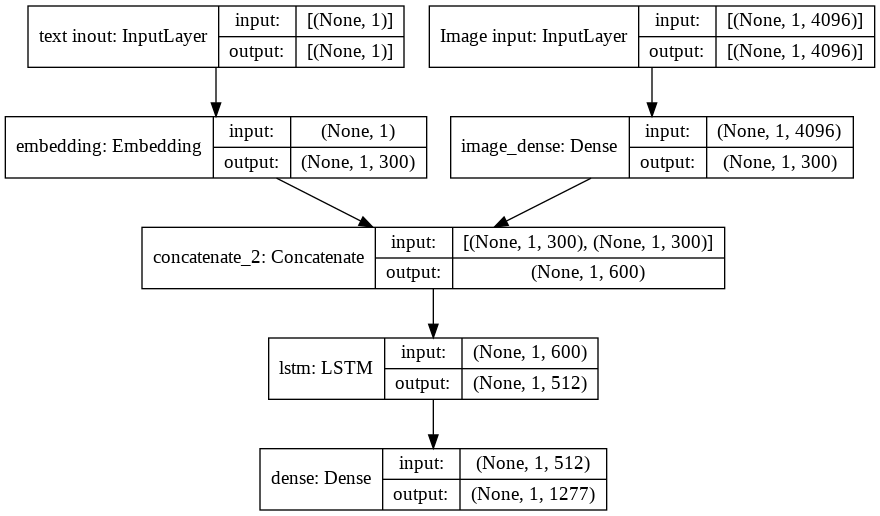

In [268]:
tf.keras.utils.plot_model(model1, to_file='model_1_plot.png', show_shapes=True, show_layer_names=True)

# Encoder and Decoder

## Encoder

In [458]:
 class Encoder(tf.keras.Model) :
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.dense = Dense(units= self.embedding_dim, kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40), name = 'encoder_dense_layer')
    
    def call(self, x):
        
        x = self.dense(x)
        x = tf.nn.relu(x)

        return x

## Decoder

In [459]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.lstm_units = lstm_units

        self.embedding = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True, trainable=False, weights=[embedding_matrix], name = 'Decoder_embedding')
        self.lstm     = LSTM(self.lstm_units, return_sequences= True, 
                             return_state= True, 
                             kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40),
                             name = 'decoder_lstm')
        
        self.dense    = Dense(self.vocab_size, name = 'Decoder_dense')

        
    def call(self, x, image_features) :

        x = self.embedding(x)
        x = tf.concat([x, image_features], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.dense(output)

        return x


## Loss function 

In [460]:
# https://www.tensorflow.org/tutorials/text/image_captioning

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def  loss_func(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

  
def acc_func(real, pred):
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)


## Data loader and Model

In [461]:
embedding_dim = 300
encoder = Encoder(embedding_dim = embedding_dim)

lstm_units = 600
decoder = Decoder(embedding_dim = embedding_dim, lstm_units = lstm_units , vocab_size = vocab_size)

In [462]:
@tf.function
def train_step(tensor, target):

    loss    = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):         
            predictions = decoder(dec_input, features)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i],1)
       
    total_loss        = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

###################################################################################

#validation function
@tf.function
def val_step(tensor, target):
    loss_val = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):
            predictions_val = decoder(dec_input, features)
            loss_val += loss_func(target[:, i], predictions_val)
            test_acc += acc_func(target[:, i], predictions_val)
            dec_input = tf.expand_dims(target[:, i],1)
        
    total_loss_val = (loss_val / int(target.shape[1]))

    return loss_val, total_loss_val

In [463]:
tf.keras.backend.clear_session()
EPOCHS = 50

loss_plot_train = []
loss_plot_val = []
num_steps = 64

for epoch in (range(0, EPOCHS)):

    start = time.time()
    total_loss_train = 0
    total_loss_val   = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss= train_step(img_tensor, target)
        total_loss_train += t_loss

    loss_plot_train.append(total_loss_train / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_dataset) :
        batch_loss, t_loss = val_step(img_tensor, target)
        total_loss_val += t_loss
  

    loss_plot_val.append(total_loss_val / num_steps)

    print('Epoch {} Train Loss : {:.6f}   Test Loss : {:.6f}'.format(epoch + 1, total_loss_train / num_steps, total_loss_val / num_steps))
    print('Time taken for epoch {} sec\n'.format(time.time() - start))

Epoch 1 Train Loss : 1.277501   Test Loss : 0.379913
Time taken for epoch 138.10528779029846 sec

Epoch 2 Train Loss : 1.106830   Test Loss : 0.357462
Time taken for epoch 16.959791660308838 sec

Epoch 3 Train Loss : 1.051636   Test Loss : 0.352382
Time taken for epoch 16.9108624458313 sec

Epoch 4 Train Loss : 1.013260   Test Loss : 0.325525
Time taken for epoch 16.87551236152649 sec

Epoch 5 Train Loss : 0.957154   Test Loss : 0.303889
Time taken for epoch 16.917845726013184 sec

Epoch 6 Train Loss : 0.918125   Test Loss : 0.307176
Time taken for epoch 16.951127290725708 sec

Epoch 7 Train Loss : 0.882547   Test Loss : 0.289371
Time taken for epoch 16.927146434783936 sec

Epoch 8 Train Loss : 0.858926   Test Loss : 0.292045
Time taken for epoch 16.95381999015808 sec

Epoch 9 Train Loss : 0.839003   Test Loss : 0.287923
Time taken for epoch 16.897879362106323 sec

Epoch 10 Train Loss : 0.818093   Test Loss : 0.281351
Time taken for epoch 16.913886308670044 sec

Epoch 11 Train Loss : 0

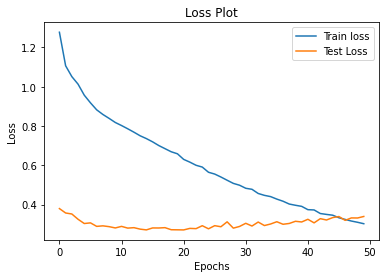

In [464]:
plt.plot(loss_plot_train, label = 'Train loss')
plt.plot(loss_plot_val, label = 'Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Prediction

In [465]:
def evaluate(image1, image2, path):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function taek images and using encoder decoder model
    and return medical report of the images
    
    '''

    img_tensor_val = preprocess(image1, image2, path)

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([token.word_index['<start>']], 1)
    features  = tf.expand_dims(features, 0)
    text = ""
    #print('image', features.shape)
    #print('dec_input', dec_input)
    max_len = 60
    for i in range(max_len):
        
        predictions = decoder(dec_input, features)
        predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        text += " " + token.index_word[predicted_id]
        
        if token.index_word[predicted_id] == '<end>':
            return text

        dec_input = tf.expand_dims([predicted_id], 1)
    return text

## Image Plotting 

In [466]:
import matplotlib.image as mpimg

def test_img_cap(img_data):
    
    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context
    
    '''
    
    path = "/content/drive/MyDrive/dl case study/NLMCXR_png/"
    result = evaluate(img_data[0],img_data[1], path = path) 
    
    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()

    print('Acutal :', img_data[2])
    print("Predicted:",result)
    print('BLEU Score :-',sentence_bleu(img_data[2], result))

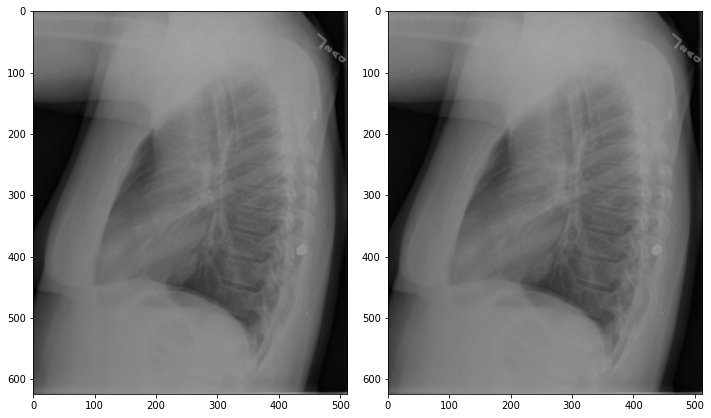

Acutal : <start> negative acute cardiopulmonary abnormality <end>
Predicted:  no acute cardiopulmonary abnormality <end>
BLEU Score :- 0.8043610129914494


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


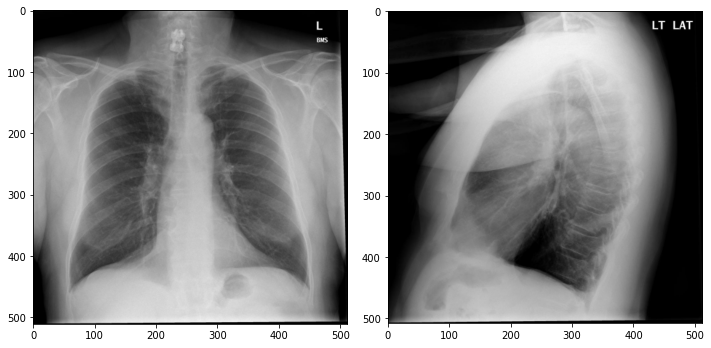

Acutal : <start> hyperexpanded clear lungs <end>
Predicted:  one no acute cardiopulmonary abnormality <end>
BLEU Score :- 0.7387670965262431


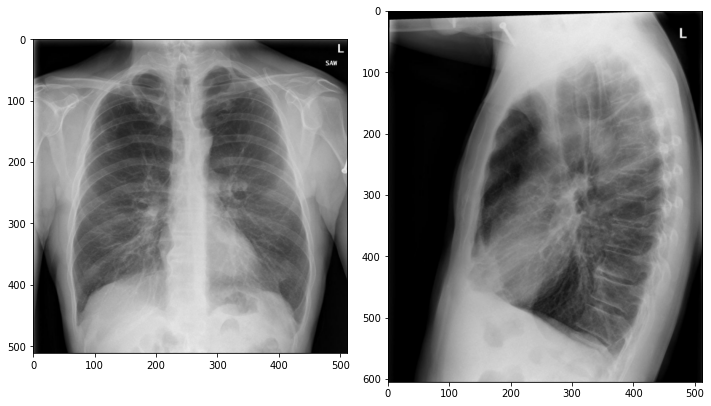

Acutal : <start> heart normal lungs clear upper lobe emphysema <end>
Predicted:  one no acute abnormality <end>
BLEU Score :- 0.8475973148300433


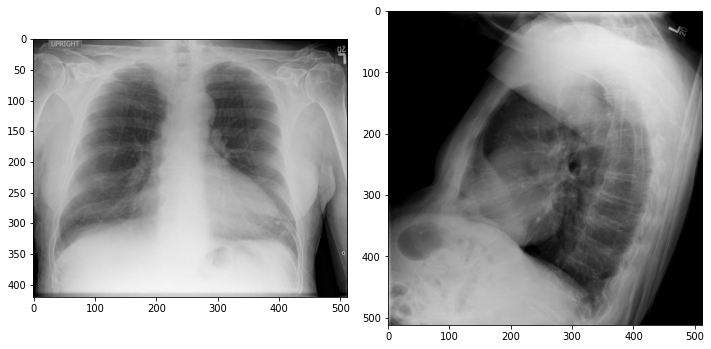

Acutal : <start> no acute findings <end>
Predicted:  definite no acute cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary
BLEU Score :- 0.3

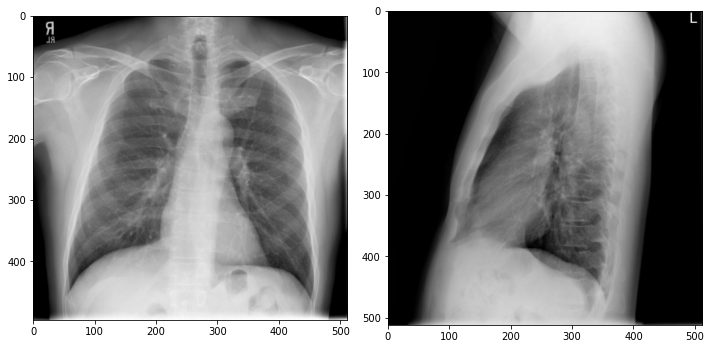

Acutal : <start> clear lungs no acute cardiopulmonary abnormality <end>
Predicted:  no comparison well expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded clear expanded
BLEU Score :- 0.4127302823483052


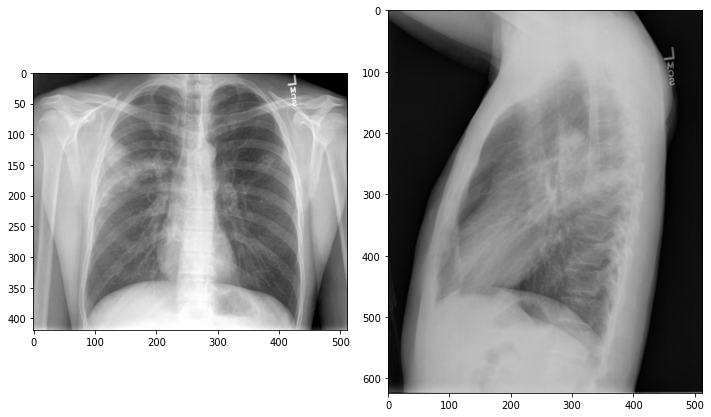

Acutal : <start> interval development bilateral upper lobe consolidation right greater left representing pneumonia followup imaging document resolution recommended <end>
Predicted:  heart size lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear lungs clear
BLEU Score :- 0.43622668206117454


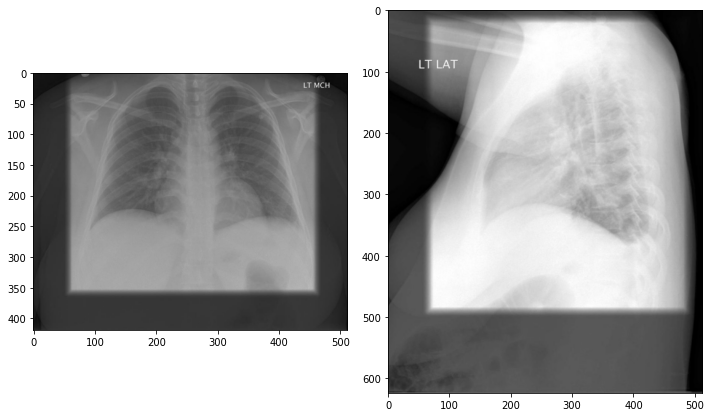

Acutal : <start> small left pleural effusion left basilar atelectasis <end>
Predicted:  no acute cardiopulmonary abnormality <end>
BLEU Score :- 0.7929487456557408


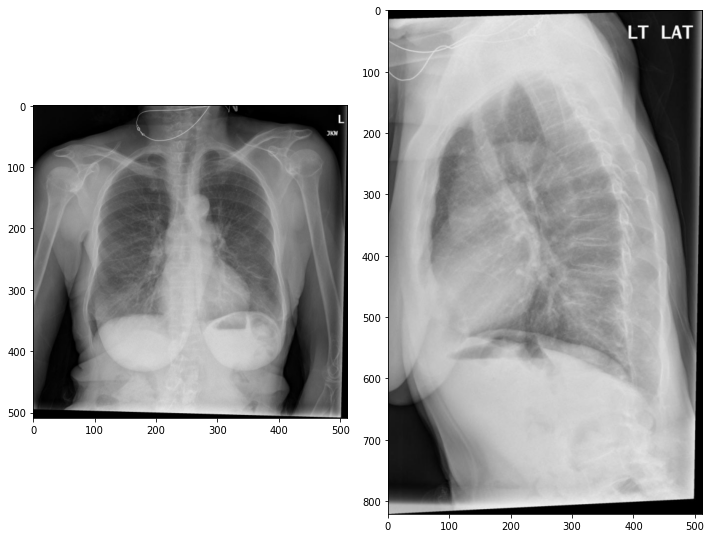

Acutal : <start> changes chronic lung disease without acute cardiopulmonary abnormality <end>
Predicted:  mild left upper lobe <end>
BLEU Score :- 0.8633400213704505


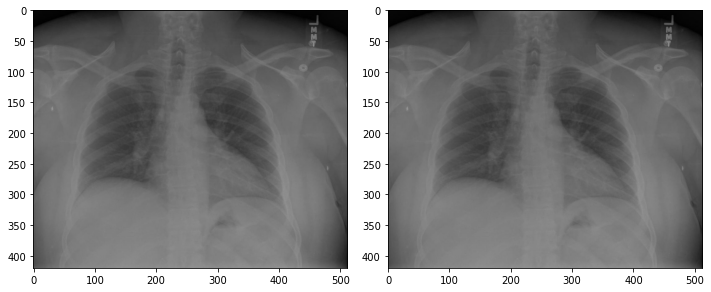

Acutal : <start> no acute disease <end>
Predicted:  no acute cardiopulmonary disease <end>
BLEU Score :- 0.7740443718000138


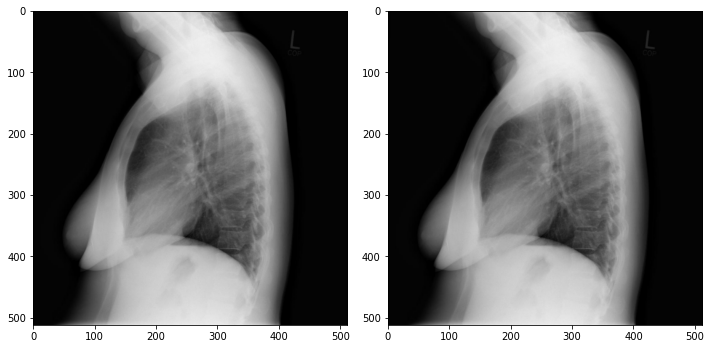

Acutal : <start> no acute findings <end>
Predicted:  no acute cardiopulmonary disease <end>
BLEU Score :- 0.7740443718000138


In [468]:
for i in test.values[18:28]:
    test_img_cap(i)

# Observation :

* We observe in above predictions, our model not good perform in long sentence.

* Our model best perform in short report and wrost perform in long report.

* Some medical reports are meaning less and not useful.

* Our model good perform in short sentence.

* This is basic model, we used LSTM model with inception generated tensors, we will use attention mechanism to improve the long setence dependancy.

* We will chestXnet use pre trained model as encoder with attnetion model, we will modify pre trained for our use.